# Random Forest Classifier

The third (and final) shallow learning model tested by Zheng et. al for their electricity theft detection problems.

Expected to outperform SVM and Logistic Regression. 

Specified hyperparameters are
- Number of trees: 200
- Function to measure quality of split: `gini`

# Workspace Setup

In [0]:
import numpy as np 
import pandas as pd 

# Seeding random number generator
np.random.seed(42)

# Plotting imports
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# Seaborn used for distribution 
from seaborn import distplot 

# Scikit Model imports 
from sklearn.ensemble import RandomForestClassifier

# Scikit Imports - data processing and splitting
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, plot_roc_curve


# Importing AUC as a metric from Tensorflow's distribution of Keras
%tensorflow_version 2.x
from tensorflow.keras.metrics import AUC

# Functions

## Function 1 - Classification Result

In [0]:
def get_classification_result(estimator, X, y_true, classifier_name=None, 
                              normalize_conf_mat='all'):
  # Get the predicted classes for this classifier
  y_pred = estimator.predict(X)

  # Display the classification report
  print("CLASSIFICATION REPORT")
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # Confusion Matrix processing 
  if (normalize_conf_mat=='rows'):
    normalize = 'true'
  elif normalize_conf_mat=='cols':
    normalize = 'pred'
  else:
    normalize = normalize_conf_mat

  # Use built-in function to get confusion matrix
  conf_mat_display = plot_confusion_matrix(estimator, 
                                           X, y_true, 
                                           labels=[0, 1], 
                                           normalize=normalize,
                                           display_labels=['Regular Consumers', 'Thieves'], 
                                           cmap='Blues')
  
  # Render the confusion matrix
  print(conf_mat_display.confusion_matrix)

  # Do not render the grid lines in the confusion matrix
  plt.grid(False)

  # Add a title to the confusion matrix
  conf_mat_display.ax_.set_title('Confusion Matrix' + 
                                 ('' if classifier_name is None else ' - {}'.format(classifier_name)), 
                                 fontsize=18)
  
  # Display ROC curve
  roc_curve_display = plot_roc_curve(estimator, X, y_true)
  roc_curve_display.ax_.set_title('Confusion Matrix' + ('' if classifier_name is None 
                                     else ' - {}'.format(classifier_name)), 
               fontsize=18);

# Loading Data

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
raw_data = pd.read_csv(filepath)

In [0]:
# Extracting features and labesl
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [5]:
kWhs.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-02-08,2014-02-09,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,6.73,6.97,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Scaling

### Standard Scaling

In [0]:
# Instantiate a StandardScaler object
standardScaler = StandardScaler()

In [0]:
# Tranpose kWhs to scale on consumer-basis, retranspose after scaling
X_scaled_std = standardScaler.fit_transform(kWhs.transpose()).transpose()

In [8]:
# Confirm shape correct
X_scaled_std.shape

(42372, 1034)

Text(0.5, 1.0, 'Distribution of kWh Values \nAfter Standard Scaling')

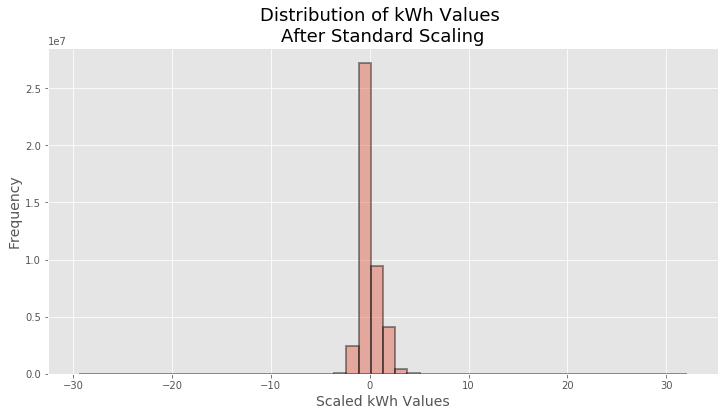

In [11]:
# Examine distribution
plt.figure(figsize=(12, 6))
distplot(X_scaled_std.ravel(), kde=False, 
         hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('Scaled kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of kWh Values \nAfter Standard Scaling', fontsize=18)

### MinMax Scaling

In [0]:
# Instantiate a MinMaxScaler
minMaxScaler = MinMaxScaler()

In [0]:
# Fit scaler to transposed features, then retranspose
X_scaled_minmax = minMaxScaler.fit_transform(kWhs.transpose()).transpose()

In [27]:
# Is the shape correct?
X_scaled_minmax.shape

(42372, 1034)

Text(0.5, 1.0, 'Distribution of kWh Values \nAfter MinMax Scaling')

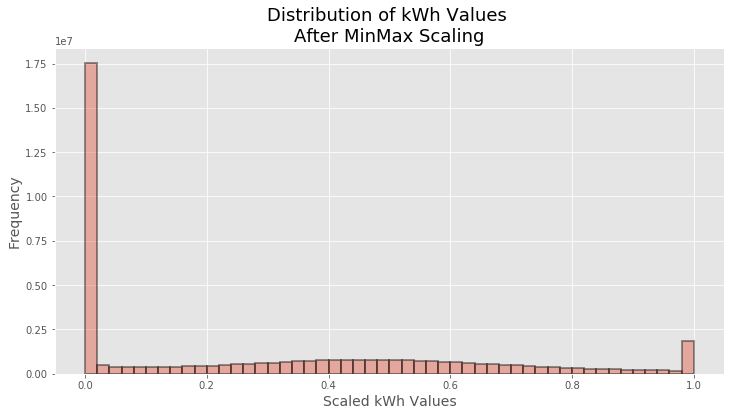

In [28]:
# Examine distribution
plt.figure(figsize=(12, 6))
distplot(X_scaled_minmax.ravel(), kde=False, 
         hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('Scaled kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of kWh Values \nAfter MinMax Scaling', fontsize=18)

# Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2, 
                                                    random_state=0)

# Zheng's Random Forest Classifier

In [0]:
rf_clf_zheng = RandomForestClassifier(n_estimators=200, 
                                      criterion='gini', 
                                      verbose=2)

## Training on Entire Dataset

In [0]:
rf_clf_zheng.fit(X_train, y_train)

In [20]:
rf_clf_zheng.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 2,
 'warm_start': False}

## Test Set Performance

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
           Thief       0.88      0.03      0.06       723

        accuracy                           0.92      8475
       macro avg       0.90      0.51      0.51      8475
    weighted avg       0.91      0.92      0.88      8475



[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[[9.14336283e-01 3.53982301e-04]
 [8.28318584e-02 2.47787611e-03]]


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


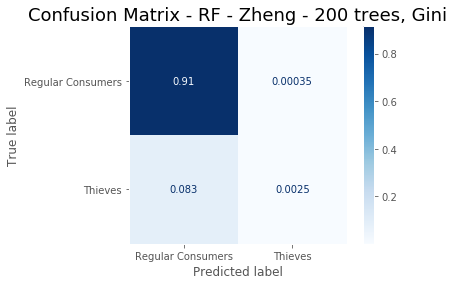

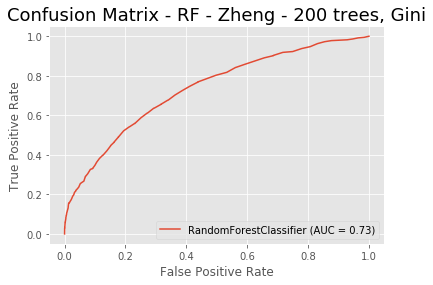

In [94]:
get_classification_result(estimator=rf_clf_zheng, X=X_test, y_true=y_test,
                          classifier_name='RF - Zheng - 200 trees, Gini')